<a href="https://colab.research.google.com/github/verma-saloni/Thesis-Alternate-Commits/blob/master/CM_Politifact_Hybrid_KNN_Epochs_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# First we import the required libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Fake 0
Real 1

In [ ]:
df_fake = pd.read_csv('/content/drive/MyDrive/politifact_fake.csv')
df_real = pd.read_csv('/content/drive/MyDrive/politifact_real.csv')
df_fake['labelML']=0
df_real['labelML']=1

df_fake.count()


id           432
news_url     428
title        432
tweet_ids    392
labelML      432
dtype: int64

In [ ]:
#df= df_fake.head(10).append(df_real.head(10))
news= df_fake.append(df_real)
news.reset_index(drop=True, inplace=True)

In [ ]:
news.head()

,id,news_url,title,tweet_ids,labelML
0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...,0
1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...,0
2,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...,0
3,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...,0
4,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...,0


In [ ]:
news = news.drop(['tweet_ids', 'news_url','id'], axis=1)
news.count()

title      1056
labelML    1056
dtype: int64

In [ ]:
news

,title,labelML
0,BREAKING: First NFL Team Declares Bankruptcy O...,0
1,Court Orders Obama To Pay $400 Million In Rest...,0
2,UPDATE: Second Roy Moore Accuser Works For Mic...,0
3,Oscar Pistorius Attempts To Commit Suicide,0
4,Trump Votes For Death Penalty For Being Gay,0
...,...,...
1051,Flake: “Religious tests should have no place i...,1
1052,Change We Can Believe In,1
1053,deputy director of national health statistics ...,1
1054,Romneys ProLife Conversion Myth or Reality Jun...,1


In [ ]:
news.dtypes

title      object
labelML     int64
dtype: object

In [ ]:
news.labelML.isna().any()

False

In [ ]:
# news['labelML'] = news['labelML'].fillna(0).astype(np.int64)

In [ ]:
news.count()

title      1056
labelML    1056
dtype: int64

In [ ]:
news.head()

,title,labelML
0,BREAKING: First NFL Team Declares Bankruptcy O...,0
1,Court Orders Obama To Pay $400 Million In Rest...,0
2,UPDATE: Second Roy Moore Accuser Works For Mic...,0
3,Oscar Pistorius Attempts To Commit Suicide,0
4,Trump Votes For Death Penalty For Being Gay,0


In [ ]:
import nltk
nltk.download('stopwords')

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
news['title']= news['title'].apply(denoise_text)


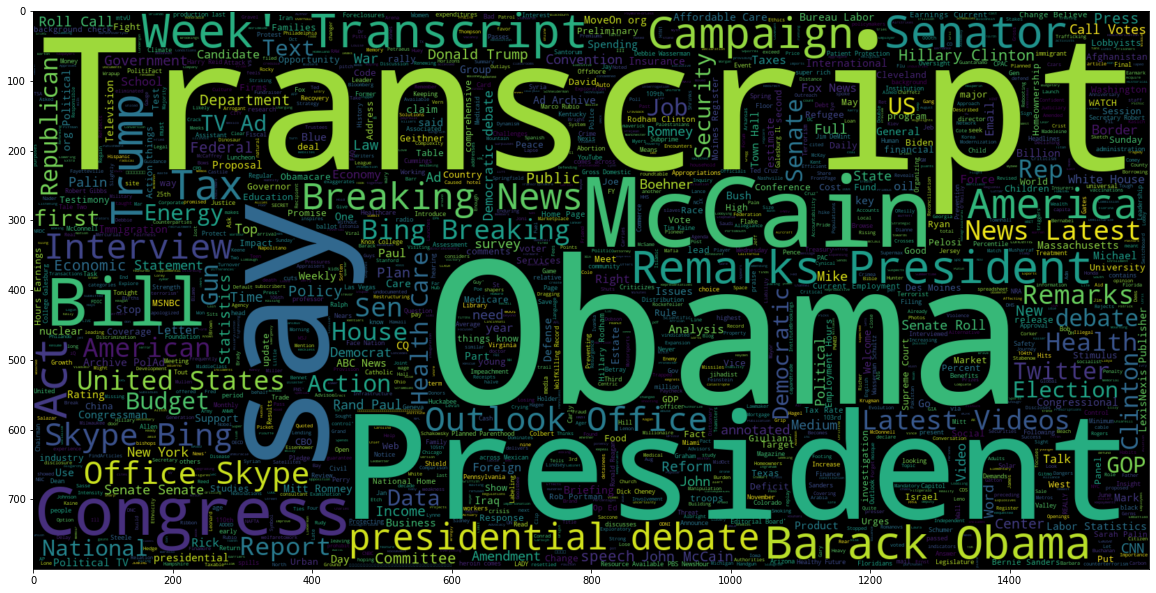

In [ ]:
#WORDCLOUD FOR REAL TEXT (LABEL - 1)
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(news[news.labelML == 1].title))
plt.imshow(wc , interpolation = 'bilinear')

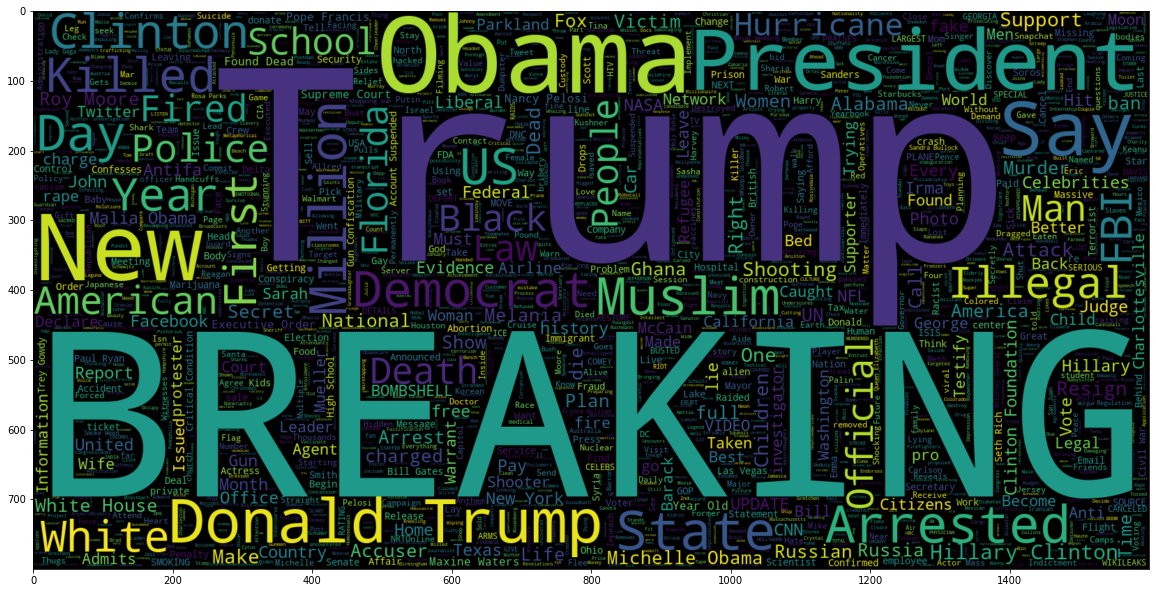

In [ ]:
#WORDCLOUD FOR Fake TEXT (LABEL - 0)
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(news[news.labelML == 0].title))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
#Splitting the data into 2 parts - training and testing data
x_train,x_test,y_train,y_test = train_test_split(news.title,news.labelML,test_size=0.1,random_state=42)
max_features = 3281
maxlen = 300

In [ ]:
#Tokenizing Text -> Repsesenting each word by a number
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [ ]:
#tokenizer.get_config()

In [ ]:
max(tokenizer.word_index.values())

3280

In [29]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [30]:
#Glove
EMBEDDING_FILE = '/content/drive/MyDrive/glove.6B.50d.txt'

In [31]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [32]:
len(embeddings_index['question'])

50

from tensorflow.python.ops.array_ops import zeros
from pandas.core.arrays.sparse import array
1. form an empty list, holds embedding confusion_matrix
.. add empty array to array of zeros- padding token
2. iterate from smaller toekn no to biggest token no 0....n, token[0]=empty array
3. for each no, find what is the word and look it up in the all_embs, then append to embedding emb matrix


In [33]:
emb_matrix=list()
emb_matrix.append(np.zeros(50,dtype=np.float32))
for i in range(1,max(tokenizer.word_index.values())+1):
  word = tokenizer.index_word[i]
  if word not in embeddings_index:
    emb_matrix.append(np.zeros(50,dtype=np.float32))
  else: 
    emb_matrix.append(embeddings_index[word]) 

In [34]:
emb_matrix

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([ 0.45769  ,  0.85191  ,  0.31098  ,  1.3478   , -0.021703 ,
        -0.05467  , -0.17405  , -0.71014  , -0.57441  ,  0.49786  ,
        -0.89382  ,  0.58661  , -0.77013  ,  0.23779  ,  0.37652  ,
         1.3668   ,  0.34667  ,  0.082452 ,  0.17561  ,  0.056062 ,
         0.50818  ,  0.33751  , -0.8517   ,  0.034619 , -0.57237  ,
        -1.1534   , -0.54159  ,  0.24328  ,  0.018737 , -0.58645  ,
         0.15261  ,  0.53372  , -0.27601  ,  0.065097 ,  0.3968   ,
        -0.62892  ,  0.0046726,  0.081347 , -0.32579  , -0.60933  ,
        -0.36464  ,  0.17591  ,  0.0050718,  1.3606   , -0.78583  ,
         0.083121 , -0.75184  , -0.74226  ,  0.77053  ,  0.26394  ],
       dtype=float32),
 array([ 0.088383,  0.64673 ,  1.1358  , -0.4184

In [35]:
print(type(emb_matrix[0]) )

<class 'numpy.ndarray'>


In [36]:
emb_matrix[1]

array([ 0.45769  ,  0.85191  ,  0.31098  ,  1.3478   , -0.021703 ,
       -0.05467  , -0.17405  , -0.71014  , -0.57441  ,  0.49786  ,
       -0.89382  ,  0.58661  , -0.77013  ,  0.23779  ,  0.37652  ,
        1.3668   ,  0.34667  ,  0.082452 ,  0.17561  ,  0.056062 ,
        0.50818  ,  0.33751  , -0.8517   ,  0.034619 , -0.57237  ,
       -1.1534   , -0.54159  ,  0.24328  ,  0.018737 , -0.58645  ,
        0.15261  ,  0.53372  , -0.27601  ,  0.065097 ,  0.3968   ,
       -0.62892  ,  0.0046726,  0.081347 , -0.32579  , -0.60933  ,
       -0.36464  ,  0.17591  ,  0.0050718,  1.3606   , -0.78583  ,
        0.083121 , -0.75184  , -0.74226  ,  0.77053  ,  0.26394  ],
      dtype=float32)

In [37]:
batch_size = 256
epochs = 50
embed_size = 50
tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)

per_process_gpu_memory_fraction: 0.333

In [38]:
#with Gabriel
#Defining Neural Network
# model = Sequential()
#Non-trainable embeddidng layer
# model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
# model.add(LSTM(units=128 , return_sequences = True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=64))
# model.add(Dropout(0.1))
# model.add(Dense(units = 32 , activation = 'relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
emb_matrix2 = np.array(emb_matrix)
#Hybrid Neural Network
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, output_dim=embed_size, weights=[emb_matrix2],trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])



In [39]:
model.compile(loss='mae',optimizer='Adam',metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          164050    
                                                                 
 dropout (Dropout)           (None, None, 50)          0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         32128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, None, 20)          11920     
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                        

In [41]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test, y_test), epochs=epochs)


Epoch 1/50
4/4 [==============================] - 16s 460ms/step - loss: 0.4939 - accuracy: 0.5789 - val_loss: 0.4828 - val_accuracy: 0.5755
Epoch 2/50
4/4 [==============================] - 0s 72ms/step - loss: 0.4527 - accuracy: 0.5968 - val_loss: 0.4376 - val_accuracy: 0.5755
Epoch 3/50
4/4 [==============================] - 0s 71ms/step - loss: 0.3586 - accuracy: 0.6632 - val_loss: 0.3789 - val_accuracy: 0.6509
Epoch 4/50
4/4 [==============================] - 0s 67ms/step - loss: 0.2558 - accuracy: 0.7968 - val_loss: 0.3161 - val_accuracy: 0.6887
Epoch 5/50
4/4 [==============================] - 0s 74ms/step - loss: 0.1969 - accuracy: 0.8189 - val_loss: 0.2885 - val_accuracy: 0.7170
Epoch 6/50
4/4 [==============================] - 0s 70ms/step - loss: 0.1716 - accuracy: 0.8358 - val_loss: 0.2683 - val_accuracy: 0.7547
Epoch 7/50
4/4 [==============================] - 0s 71ms/step - loss: 0.1517 - accuracy: 0.8537 - val_loss: 0.2780 - val_accuracy: 0.7170
Epoch 8/50
4/4 [=========

In [42]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train))


30/30 [==============================] - 0s 13ms/step - loss: 0.0524 - accuracy: 0.9474
Accuracy of the model on Training Data is -  [0.05236295983195305, 0.9473684430122375]


In [43]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

4/4 [==============================] - 0s 15ms/step - loss: 0.2259 - accuracy: 0.7736
Accuracy of the model on Testing Data is -  77.35849022865295


In [44]:
epochs

50

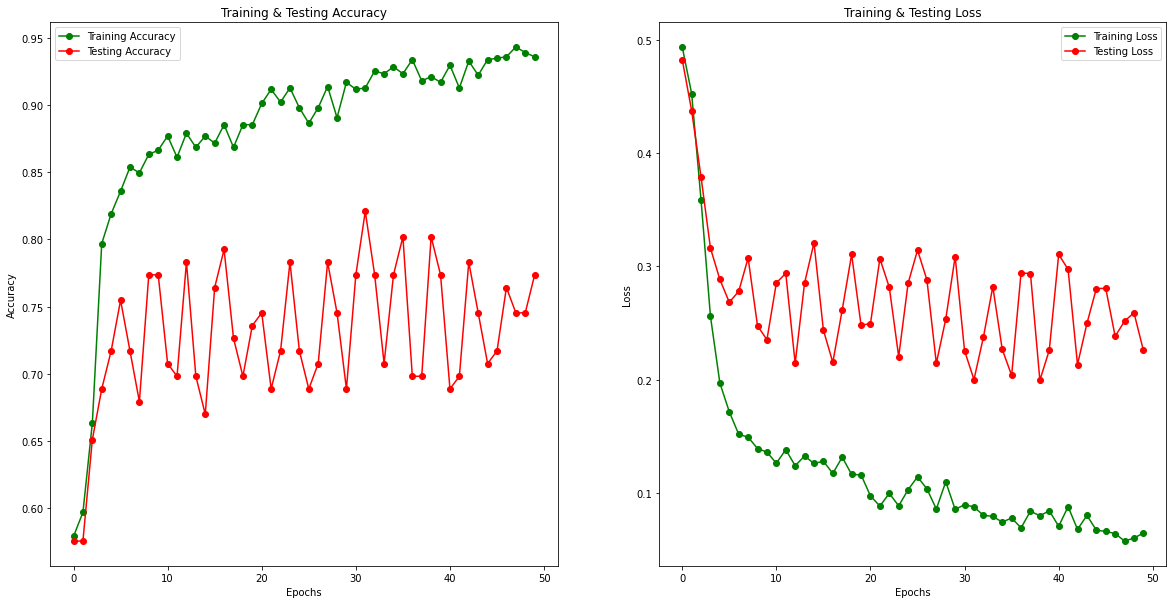

In [45]:
epoch_list = [i for i in range(0,epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epoch_list , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epoch_list , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epoch_list , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epoch_list , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

Leads me to believe that maybe there is some overfitting going on, or adjusting other parameters for the model would help. 


In [46]:
!pip install np_utils
from keras.utils.np_utils import to_categorical

     |████████████████████████████████| 61 kB 474 kB/s 
  Created wheel for np-utils: filename=np_utils-0.6.0-py3-none-any.whl size=56459 sha256=3e4e80100e3fc0d48bf36f21be3d6ce2a7c71570f935183610b6be4b55bc1657
  Stored in directory: /root/.cache/pip/wheels/d2/83/71/a781667865955ae7dc18e5a4038401deb56d96eb85d3a5f1c0
Successfully built np-utils


In [47]:
pred = model.predict(x_train)
pred_classes = tf.keras.utils.to_categorical(pred)
pred_test = model.predict(X_test)
pred_test_classes = tf.keras.utils.to_categorical(pred_test)

Final layer has sigmoid activation. If pred < 0.5 class is 0 (Fake), else 1 (Real)

In [48]:
pred_train_classes = (pred > 0.5).astype(int)
pred_test_classes = (pred_test > 0.5).astype(int)

In [49]:
(pred_train_classes.squeeze() == y_train).mean()
(pred_test_classes.squeeze() == y_test).mean()

0.7735849056603774

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay

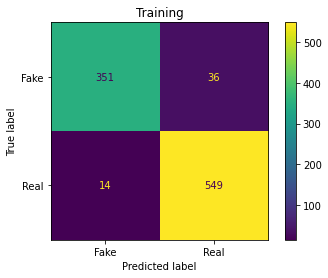

In [51]:
cmdisp = ConfusionMatrixDisplay.from_predictions(y_train, pred_train_classes, display_labels=["Fake", "Real"])
cmdisp.ax_.set_title("Training")
plt.show()

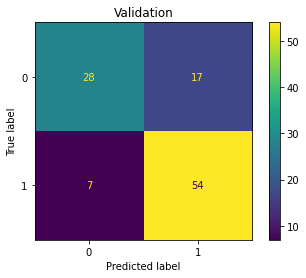

In [52]:
cmdisp = ConfusionMatrixDisplay.from_predictions(y_test, pred_test_classes)
cmdisp.ax_.set_title("Validation")
plt.show()

In [53]:
from collections import Counter


print(Counter(y_test).keys()) # equals to list(set(words))
print(Counter(y_test).values())

dict_keys([0, 1])
dict_values([45, 61])


Add confusion matrix, fix type of classes.

In [54]:
sentence = ["All the universities and schools remain closed for two months due to the corona virus outbreak in the country."]
sequences = tokenizer.texts_to_sequences(sentence)
padded = sequence.pad_sequences(sequences, maxlen=maxlen)
model_decision = model.predict(padded)
print(model_decision)

[[1.2192676e-14]]


In [55]:
tf.keras.utils.to_categorical(model_decision)

array([[1.]], dtype=float32)

Predicts 1, ie Real. Probable news source is good.


In [56]:
sentence1 = ["leeee keen to nooo where leaves"]
sequences1 = tokenizer.texts_to_sequences(sentence)
padded1 = sequence.pad_sequences(sequences1, maxlen=maxlen)
model_decision1 = model.predict(padded1)
print(model_decision1)

[[1.2192676e-14]]


In [57]:
tf.keras.utils.to_categorical(model_decision1)

array([[1.]], dtype=float32)

Probably has a tendency to predict more real, overfitting? check. softmax always predicts 1 errors? need to be fixed. 